# Final output

In [1]:
import pandas as pd
import numpy as np
import re 

import warnings
def noop(*args, **kargs): pass
warnings.warn = noop

import gensim
from gensim import utils, models
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
#from gensim.parsing.preprocessing import STOPWORDS as SW

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis
import pyLDAvis.gensim_models as gensimviz
from wordcloud import WordCloud


In [2]:
df = pd.read_pickle('data/spacy_lemmatized.pkl') 

# Load pickle from disk
#df = pd.read_pickle('data/spacy_lemmatized.pkl', compression='gzip')
df.head()

,text,tokens,tokens_back_to_text,lemmas
0,tuo on itseasiassa erinomainen kysymys. miksi ...,"[itseasiassa, erinomainen, kysymys., pilvet, m...",itseasiassa erinomainen kysymys. pilvet majail...,"[itseasia, erinomainen, kysymys, pilvi, majail..."
1,"niin tässä kai on pointtina se, että tuoreen t...","[pointtina, se,, tuoreen, tutkimustiedonkin, (...","pointtina se, tuoreen tutkimustiedonkin ( lail...","[pointti, tuore, tutkimustiedonkki, laillistam..."
2,"on kyllä huvittavaa, kuinka lääke 'ta kivun li...","[huvittavaa,, lääke, 'ta, kivun, lievitykseen,...","huvittavaa, lääke 'ta kivun lievitykseen vastu...","[huvittava, lääke, ta, kipu, lievitys, vastust..."
3,saatiinko suomeen nyt ensimmäinen poliisiminis...,"[saatiinko, suomeen, poliisiministeri,, kannab...","saatiinko suomeen poliisiministeri, kannabikse...","[saatiinko, suomeen, poliisiministeri, kannabi..."
4,"mitä enemmän kannabista myydään, sitä enemmän ...","[kannabista, myydään,, saadaan, verotuloja,, k...","kannabista myydään, saadaan verotuloja, käytet...","[kannabinen, myydä, saada, verotulo, käyttää, ..."


In [3]:
def word_cleaning(text):
    word_list= ['kannabis', 'kannabiksen', 'kannabinen', 'kannabiknen', 'kannabikse', 'Kannabis', 'mut']
    tokens = [word for word in text if not word in word_list]
    return tokens

In [4]:
# removing search keywords
#df['final_tokens'] = df['lemma_tokens'].apply(word_cleaning)
data_ready =df['lemmas'].apply(word_cleaning)  # processed Text Data!
#data_ready =df['text_tokenized'].apply(word_cleaning)  # processed Text Data!


#data_ready.head()

# LDA Model

In [5]:
# Gensim Dictionary
# Filter out words that occur less than 5 documents, or more than 98% of the documents.

extremes_no_below = 2 
extremes_no_above = 0.99

# LDA
topic_number_set = 15
pass_set = 30
chunk_set = 2000
#alpha_set = 'symmetric', # 'asymmetric',
iteration_set= 60
probability_set=0.5
decay_set=0.1

In [6]:
# Create a id2word dictionary
#id2word = Dictionary(df['final_tokens'])
id2word = Dictionary(data_ready )
print(len(id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=extremes_no_below, no_above=extremes_no_above)
print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in data_ready ]

31812
10588


In [7]:
# developed in GESIM NLP LDA codebook
lda_model = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics= topic_number_set,
                       random_state=42,
                       chunksize=chunk_set,
                       passes=pass_set,
                       decay=decay_set,
                       #alpha = alpha,
                       iterations=iteration_set,
                       minimum_probability=probability_set) 

In [8]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
myynti käyttö laiton laillinen Suomi pitää haitto rikollisuus kieltolaki verotulo

------ Topic 1 ------
psykoosi olla aiheuttaa alkoholi vaikuttaa ongelma käyttö näyttää nuori laukaistaa

------ Topic 2 ------
maito hamppu elimistö vihreä laillistaa syödä lapsi käyttää pois puhua

------ Topic 3 ------
vihreä laillistaminen käyttää käyttö puhua tietää salliminen syy vastata kieltää

------ Topic 4 ------
laillistaminen kannattaa Suomi vihreä saada olla käyttää alkaa tehdä pitää

------ Topic 5 ------
käyttö huume nuori laillistaminen pitää käyttää lisääntyä Suomi ongelma laki

------ Topic 6 ------
laillistaa Suomi cbd laillistaminen käyttö rikollinen saada rikos mieli nähdä

------ Topic 7 ------
aiheuttaa aine huumeisi alkoholi toimia tietää käyttää portti osa ihminen

------ Topic 8 ------
kokeilla ihminen ei ongelma alkoholi käyttäjä kun lääke käyttää tuntea

------ Topic 9 ------
laillistaminen kanta keskustelu puolue vihreä pitää vastustaa mieli tehdä saada

In [9]:
# Compute Perplexity
# a measure of how good the model is. lower the better
model_perplexity = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', model_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts= data_ready, 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model)


Perplexity:  -8.359762545965419

Coherence Score:  0.2902802147496625


In [10]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
viz=gensimviz.prepare(lda_model, corpus, id2word)
viz

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/past/builti

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.024535 -0.182241       1        1  10.645707
5      0.017773 -0.084897       2        1   9.122625
0      0.043765 -0.147223       3        1   8.817082
9      0.180585  0.059377       4        1   8.139401
14    -0.135685 -0.092985       5        1   7.534144
10     0.053125 -0.020750       6        1   6.794395
4      0.154810 -0.019101       7        1   6.317200
12    -0.100257  0.038463       8        1   6.083375
1     -0.118766  0.093312       9        1   5.619093
8     -0.078333  0.006759      10        1   5.417700
7     -0.107043  0.040790      11        1   5.357821
3      0.084603  0.087136      12        1   5.231546
11     0.003527  0.109821      13        1   5.180711
6      0.074784  0.013554      14        1   5.143953
2     -0.048354  0.097984      15        1   4.595249, topic_info=               Term         Freq        Total Category  logprob  loglift
354        alkoholi  1396.000000  1396.000000  Default  30.0000  30.0000
8    laillistaminen  1573.000000  1573.000000  Default  29.0000  29.0000
38            saada  1545.000000  1545.000000  Default  28.0000  28.0000
7            käyttö  1812.000000  1812.000000  Default  27.0000  27.0000
132          vihreä   727.000000   727.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
128           tehdä    20.930172   692.778627  Topic15  -5.6560  -0.4194
175           pitää    21.212045   949.592492  Topic15  -5.6426  -0.7213
597        käyttäjä    19.414307   449.123586  Topic15  -5.7312  -0.0611
366     suomalainen    18.318843   216.710691  Topic15  -5.7893   0.6095
9             nuori    19.420351   629.987775  Topic15  -5.7309  -0.3992

[1120 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4464     10  0.860006      -ilmiöt
690       3  0.940188  -kertaistaa
6159      2  0.808029  -vuotiaiden
6159      9  0.089781  -vuotiaiden
1430      6  0.215370  -vuotiaista
...     ...       ...          ...
522      11  0.085048         ääni
522      13  0.021262         ääni
8390     13  0.929231         önce
5524      5  0.861653        överi
8391     13  0.948628       гянджа

[3316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 6, 1, 10, 15, 11, 5, 13, 2, 9, 8, 4, 12, 7, 3])

In [11]:
pyLDAvis.save_html(viz, 'data/lda_2.html')

# Dominant topics and in each document II


In [12]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ 
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts= df['text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.9066,"laillistaa, Suomi, cbd, laillistaminen, käyttö...",tuo on itseasiassa erinomainen kysymys. miksi ...
1,1,5.0,0.8667,"käyttö, huume, nuori, laillistaminen, pitää, k...","niin tässä kai on pointtina se, että tuoreen t..."
2,2,2.0,0.9417,"maito, hamppu, elimistö, vihreä, laillistaa, s...","on kyllä huvittavaa, kuinka lääke 'ta kivun li..."
3,3,0.0,0.6840,"myynti, käyttö, laiton, laillinen, Suomi, pitä...",saatiinko suomeen nyt ensimmäinen poliisiminis...
4,4,5.0,0.7928,"käyttö, huume, nuori, laillistaminen, pitää, k...","mitä enemmän kannabista myydään, sitä enemmän ..."


In [13]:
#df_dominant_topic.isnull().values.any()
#nan_rows = df_dominant_topic[df_dominant_topic.isnull().T.any()]
#nan_rows

In [14]:
df_topic_distribution = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topics', 'Freq']
df_topic_distribution

,Topics,Freq
0,13.0,970
1,5.0,852
2,9.0,792
3,0.0,765
4,4.0,657
5,10.0,657
6,14.0,643
7,3.0,532
8,12.0,505
9,6.0,500


In [15]:
# How many tweets are classified?
df_topic_distribution['Freq'].sum()

9248

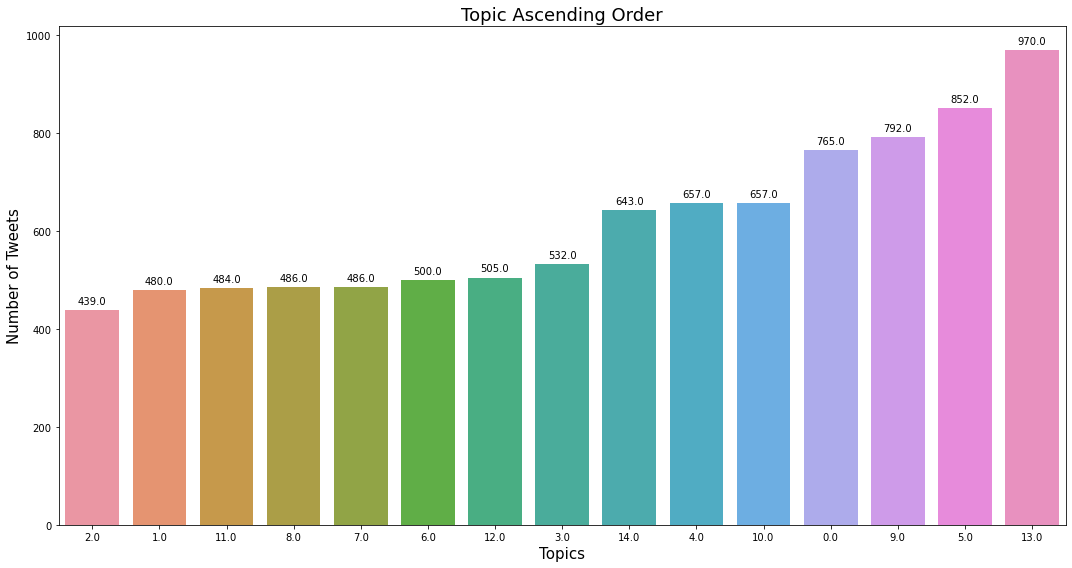

In [16]:
plt.figure(figsize=(15,8))
# make barplot and sort bars
ax= sns.barplot(x='Topics',
            y="Freq", 
            data=df_topic_distribution, 
            order=df_topic_distribution.sort_values('Freq').Topics)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
# set labels
plt.xlabel("Topics", size=15)
plt.ylabel("Number of Tweets", size=15)
plt.title("Topic Ascending Order", size=18)
plt.tight_layout()
#plt.savefig("sort_bars_in_barplot_ascending_order_Seaborn_Python.png", dpi=100)

# The most representative sentence for each topic



In [17]:
#Display setting to show more characters in column
#pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(15)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9576,"myynti, käyttö, laiton, laillinen, Suomi, pitä...","se, että jokin asia on rangaistava, ei vähennä..."
1,1.0,0.9594,"psykoosi, olla, aiheuttaa, alkoholi, vaikuttaa...",kanada laillisti kannabiksen kolme vuotta sitt...
2,2.0,0.9594,"maito, hamppu, elimistö, vihreä, laillistaa, s...",kannabiksen on kumottu aikaa sitten kuulemman....
3,3.0,0.9555,"vihreä, laillistaminen, käyttää, käyttö, puhua...","ottamatta kantaa laillistamisen järkevyyteen, ..."
4,4.0,0.9575,"laillistaminen, kannattaa, Suomi, vihreä, saad...",tavallinen käyttöannos yhdelle henkilölle on m...
5,5.0,0.9594,"käyttö, huume, nuori, laillistaminen, pitää, k...","eiköhän toi kannabis /vihr ole vaalitemppu, wi..."
6,6.0,0.9594,"laillistaa, Suomi, cbd, laillistaminen, käyttö...",olen vahvasti eri mieltä. näin olisi ollut ehk...
7,7.0,0.9533,"aiheuttaa, aine, huumeisi, alkoholi, toimia, t...",tässä on sinulle sopiva ohjelma… kannabis ohje...
8,8.0,0.9594,"kokeilla, ihminen, ei, ongelma, alkoholi, käyt...",jännästi ne psykoosit sijoittuu suomessa sinne...
9,9.0,0.9533,"laillistaminen, kanta, keskustelu, puolue, vih...",erityisestl tulee mieleen alkoholimyrkytykseen...


# Frequency Distribution of Word Counts in Documents

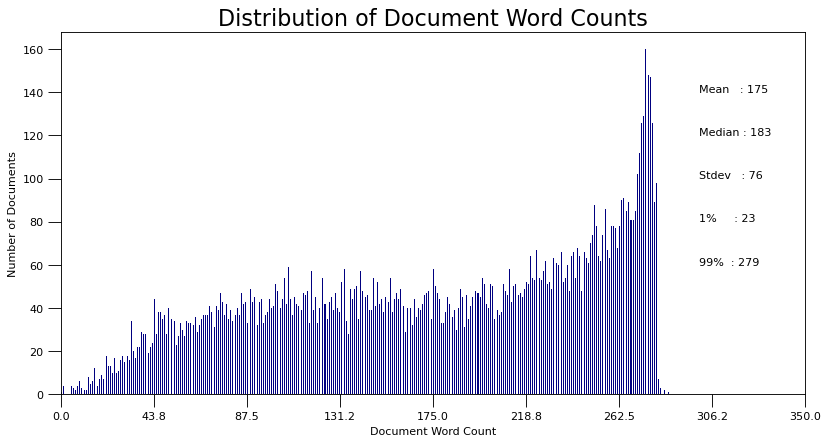

In [18]:
doc_lens = [len(d) for d in df_dominant_topic.Text]


# Plot
plt.figure(figsize=(12,6), dpi=80)
plt.hist(doc_lens, bins = 600, color='navy')
plt.text(300, 140, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(300,  120, "Median : " + str(round(np.median(doc_lens))))
plt.text(300,  100, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(300,  80, "1%     : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(300,  60, "99%  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 350), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,350,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=20))
plt.show()

# Word Clouds of Top N Keywords in Each Topic


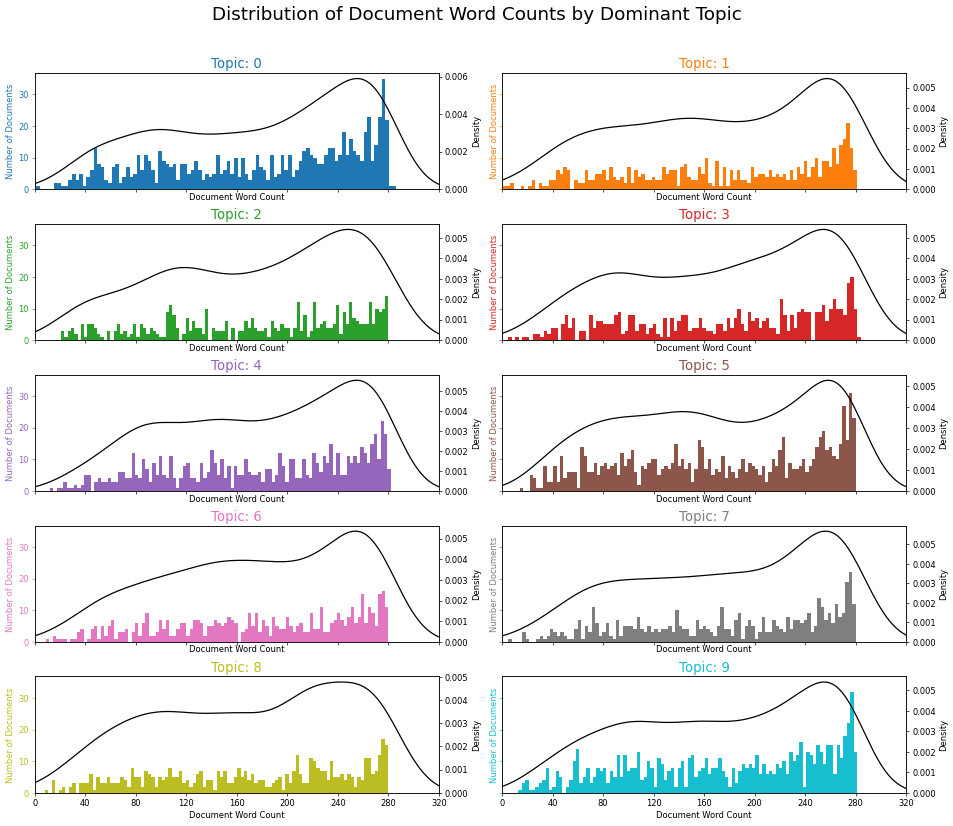

In [19]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=60, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 160), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,320,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in Each Topic

In [20]:
# https://www.kaggle.com/code/danielbecker/careervillage-org-recommendation-engine/notebook

import math

def get_model_wordcloud(ldamodel, num_topics):
    """ Create a Word Cloud for each topic of the LDA model

    """  
    plot_cols = 3
    plot_rows = math.ceil(num_topics / 3)
    axisNum = 0
    plt.figure(figsize=(6*plot_cols, 4*plot_rows))
    for topicID in range(ldamodel.state.get_lambda().shape[0]):
        #gather most relevant terms for the given topic
        topics_terms = ldamodel.state.get_lambda()
        tmpDict = {}
        for i in range(1, len(topics_terms[0])):
            tmpDict[ldamodel.id2word[i]]=topics_terms[topicID,i]

        # draw the wordcloud
        wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
        axisNum += 1
        ax = plt.subplot(plot_rows, plot_cols, axisNum)

        plt.imshow(wordcloud, interpolation='bilinear')
        title = topicID
        plt.title(title)
        plt.axis("off")
        plt.margins(x=0, y=0)
    plt.show()

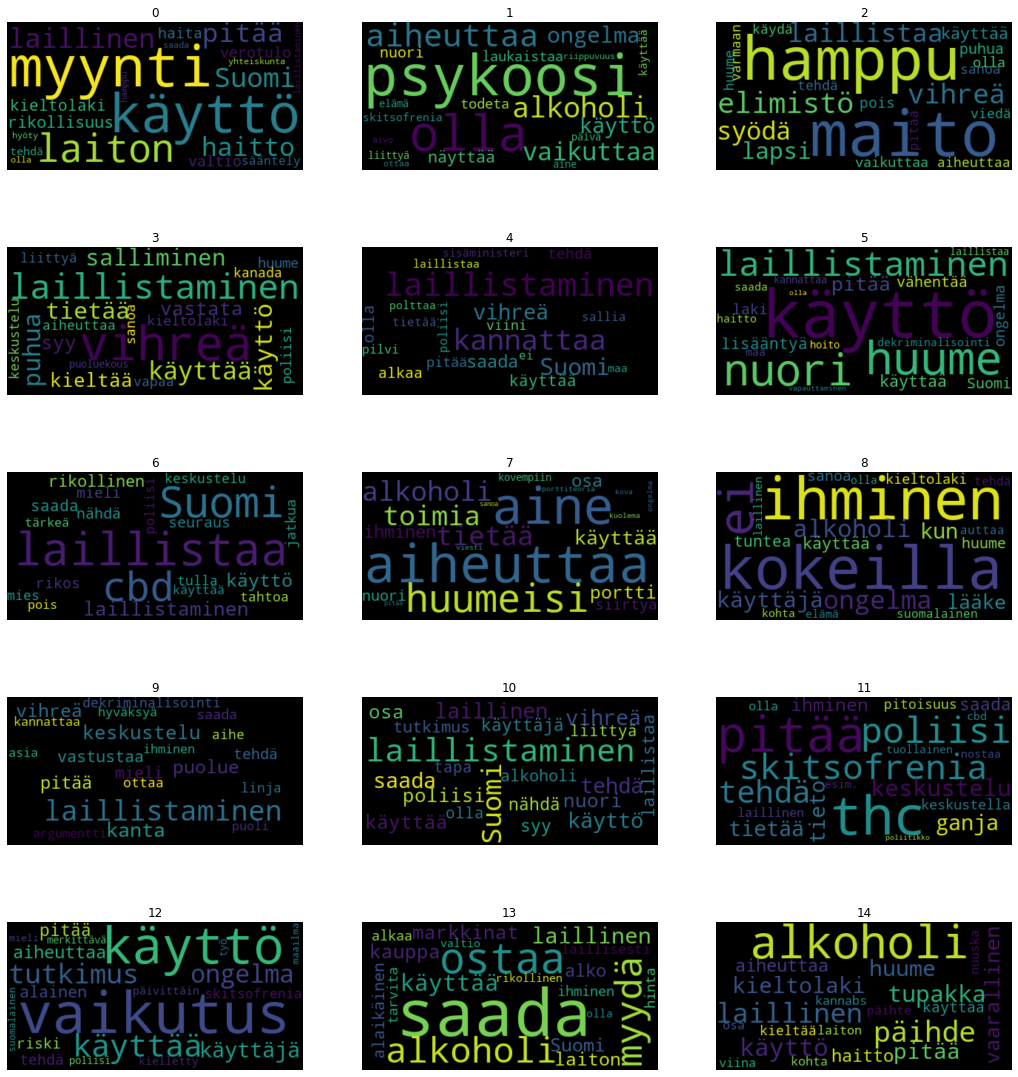

In [21]:
import warnings
def noop(*args, **kargs): pass
warnings.warn = noop

# plot
number_of_topics= 15 # number of topics
get_model_wordcloud(lda_model, number_of_topics)


# Word Counts of Topic Keywords

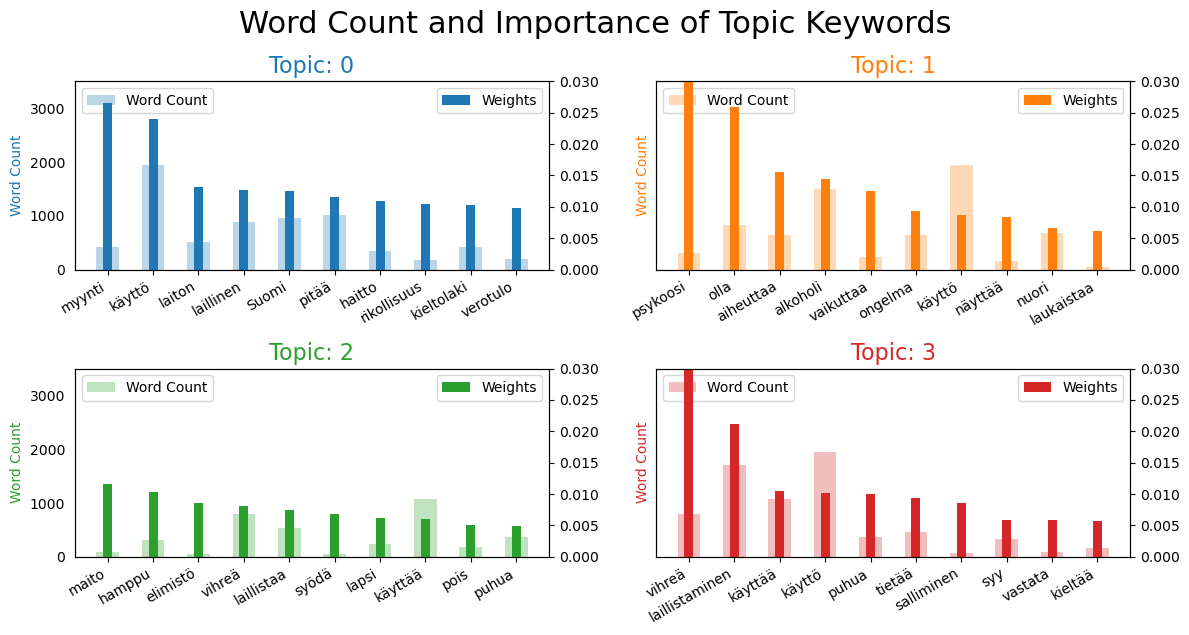

In [22]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

dff = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharey=True, dpi=100)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dff.loc[dff.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()